This tutorial is to demonstrate how researchers can adopt our proposed adaptive hyperprior along with the hidden-space featurization strategy within a BayBE workflow.

In [1]:
# pip install -r requirements.txt
# After install the required packages, restart jupyter kernel.

In [2]:
#=======================================================
# 1. Data Loading
#=======================================================

import pandas as pd

# This demo is based on one commonly used benchmark: the Shields dataset.
file_path = "shields_dataset.xlsx"
lookup = pd.read_excel(file_path, index_col=0)
lookup.head()

,Base_SMILES,Ligand_SMILES,Solvent_SMILES,Concentration,Temp_C,yield,Base,Ligand,Solvent
entry,,,,,,,,,
0,O=C([O-])C.[K+],CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC...,CC(N(C)C)=O,0.1,105,5.47,Potassium acetate,BrettPhos,DMAc
1,O=C([O-])C.[K+],CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C,CC(N(C)C)=O,0.1,105,0.00,Potassium acetate,Di-tert-butylphenylphosphine,DMAc
2,O=C([O-])C.[K+],CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C...,CC(N(C)C)=O,0.1,105,78.95,Potassium acetate,(t-Bu)PhCPhos,DMAc
3,O=C([O-])C.[K+],P(C1CCCCC1)(C2CCCCC2)C3CCCCC3,CC(N(C)C)=O,0.1,105,7.26,Potassium acetate,Tricyclohexylphosphine,DMAc
4,O=C([O-])C.[K+],P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3,CC(N(C)C)=O,0.1,105,28.15,Potassium acetate,PPh3,DMAc


In [3]:
# In Shields, we have 5 variables: Temperature, Concentration, Base, Ligand, Solvent.
print(lookup['Temp_C'].unique())

[105  90 120]


In [4]:
print(lookup['Concentration'].unique())

[0.1   0.057 0.153]


In [5]:
print(lookup['Solvent'].unique())
print(lookup['Solvent_SMILES'].unique())

['DMAc' 'Butyornitrile' 'Butyl Ester' 'p-Xylene']
['CC(N(C)C)=O' 'CCCC#N' 'CCCCOC(C)=O' 'CC1=CC=C(C)C=C1']


In [6]:
print(lookup['Base'].unique())
print(lookup['Base_SMILES'].unique())

['Potassium acetate' 'Potassium pivalate' 'Cesium acetate'
 'Cesium pivalate']
['O=C([O-])C.[K+]' 'O=C([O-])C(C)(C)C.[K+]' 'O=C([O-])C.[Cs+]'
 'O=C([O-])C(C)(C)C.[Cs+]']


In [7]:
print(lookup['Ligand'].unique())
print(lookup['Ligand_SMILES'].unique())

['BrettPhos' 'Di-tert-butylphenylphosphine' '(t-Bu)PhCPhos'
 'Tricyclohexylphosphine' 'PPh3' 'XPhos' 'P(2-furyl)3'
 'Methyldiphenylphosphine' '1268824-69-6' 'JackiePhos' 'SCHEMBL15068049'
 'Me2PPh']
['CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC3)C4CCCCC4)C(OC)=CC=C2OC'
 'CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C'
 'CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C3=CC=CC=C3'
 'P(C1CCCCC1)(C2CCCCC2)C3CCCCC3' 'P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3'
 'CC(C1=C(C2=CC=CC=C2P(C3CCCCC3)C4CCCCC4)C(C(C)C)=CC(C(C)C)=C1)C'
 'P(C1=CC=CO1)(C2=CC=CO2)C3=CC=CO3' 'CP(C1=CC=CC=C1)C2=CC=CC=C2'
 'CC(OC1=C(P(C2CCCCC2)C3CCCCC3)C(OC(C)C)=CC=C1)C'
 'FC(F)(F)C1=CC(P(C2=C(C3=C(C(C)C)C=C(C(C)C)C=C3C(C)C)C(OC)=CC=C2OC)C4=CC(C(F)(F)F)=CC(C(F)(F)F)=C4)=CC(C(F)(F)F)=C1'
 'C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@]3(C)C1'
 'CP(C)C1=CC=CC=C1']


In [8]:
# Optimization objective: maximize reaction yield
from baybe.objectives import SingleTargetObjective
from baybe.targets import NumericalTarget
F_BEST = lookup['yield'].max()
objective = SingleTargetObjective(target=NumericalTarget(name="yield", mode="MAX"))

# First normalize the two numerical variables:
from base.utils import _normalize
lookup["Temp_C"] = _normalize(lookup["Temp_C"])
lookup["Concentration"] = _normalize(lookup["Concentration"])

# Then convert them into "parameters", which is accepted in the "search space".
from baybe.parameters import NumericalDiscreteParameter
numerical_params = {
    'Temp_C': NumericalDiscreteParameter(name="Temp_C", values=set(lookup.Temp_C)),
    'Concentration': NumericalDiscreteParameter(name="Concentration", values=set(lookup.Concentration)),
}

In [9]:
#=======================================================
# 2. Hidden-space Molecular Representaion
# Optional: Decorrelation or PCA
#=======================================================

# Deal with non-numerical variables, each of which takes value from a molecular set.
# E.g., Four molecules for Solvent variable: BuOAc, p-xylene, BuCN and DMAc.
# Prepare them for molecular representation later by a given strategy.
solvent_data = dict(sorted(set(zip(lookup.Solvent, lookup.Solvent_SMILES))))
base_data = dict(sorted(set(zip(lookup.Base, lookup.Base_SMILES))))
ligand_data = dict(sorted(set(zip(lookup.Ligand, lookup.Ligand_SMILES))))

discrete_data = {
    'Solvent': solvent_data,
    'Base': base_data,
    'Ligand': ligand_data,
}

from base.pretrained_repr import PretrainedWrapper, ChemBERTa_Fingerprint, CheMeleonFingerprint, LLM_Fingerprint
from baybe.parameters import CustomDiscreteParameter
from base.utils import custom_fingerprinter, custom_PCA_fingerprinter

# Here we provide a "wrapper" for all kinds of hidden representations, see base.pretrained_repr file for detail.
fp_type = 'chemeleon'

if fp_type in ['chemeleon']:
    fingerprinter = PretrainedWrapper(CheMeleonFingerprint)
elif fp_type in ['chemberta']:
    fingerprinter = PretrainedWrapper(ChemBERTa_Fingerprint, variant='deepchem-100M-MLM')
elif fp_type in ['t5-base-chem']:
    fingerprinter = PretrainedWrapper(LLM_Fingerprint, model_name='GT4SD/multitask-text-and-chemistry-t5-base-augm', pooling_method='average', normalize_embeddings=False)
else:
    fingerprinter = None

# Supported dimension-reduction: either decorrelation (threshold 0.7/0.9) or PCA.
PCA = False
decorr_threshold = 0.7
# PCA and decorrelation are mutually-exclusive

# Convert Base, Solvent and Ligand variables into "parameters" that are accepted in the search space.
# Parameter values are generated base on the hidden-space featurization wrapper above.
# Decorrelation or PCA is implemented in this process.
mol_param_dict = {}

for name, variable_data in discrete_data.items():
    if PCA:
        mol_param_dict[name] = CustomDiscreteParameter(name=name, data=custom_PCA_fingerprinter(variable_data, fingerprinter), decorrelate=False)
    else:
        mol_param_dict[name] = CustomDiscreteParameter(name=name, data=custom_fingerprinter(variable_data, fingerprinter), decorrelate=decorr_threshold)

# Example of hidden representations:
mol_param_dict['Solvent'].comp_df

,Solvent_d_0,Solvent_d_1,Solvent_d_8,Solvent_d_26,Solvent_d_33,Solvent_d_61
Butyl Ester,0.065296,0.089903,0.000000,0.000000,0.044261,0.043514
Butyornitrile,0.027339,0.000000,0.006781,0.128882,0.000000,0.013214
DMAc,0.198976,0.000000,0.000000,0.075987,0.000000,0.117365
p-Xylene,0.235580,0.000000,0.000000,0.271472,0.063080,0.000000


In [10]:
#=======================================================
# 3. Prepare a BO: 
# search space, 
# ** kernel with our adaptive prior, **
# Gaussian Process model and Acquisition Function 
#=======================================================

# Build the search space:
# a product of all parameters.
from baybe.searchspace import SearchSpace

search_params_list = []
    
for name, parameter in mol_param_dict.items():
    search_params_list.append(parameter)

for name, parameter in numerical_params.items():
    search_params_list.append(parameter)

searchspace = SearchSpace.from_product(parameters=search_params_list)

# **Dimensionality of the search space**
feat_dim = len(searchspace.comp_rep_columns)
print(f'Dimensionality of the search space: {feat_dim}')

# Build a 5/2 Matern kernel with our proposed adaptive hyperprior
# l = 0.4 * sqrt(d) + 4.0
from baybe.kernels import ScaleKernel, MaternKernel
from baybe.priors.basic import GammaPrior
import math

x = math.sqrt(feat_dim)
l_mean = 0.4 * x + 4.0

lengthscale_prior = GammaPrior(2.0*l_mean, 2.0)
lengthscale_initial_value = l_mean
outputscale_prior = GammaPrior(1.0*l_mean, 1.0)
outputscale_initial_value = l_mean

kernel_adaptive =  ScaleKernel(
    MaternKernel(
        nu=2.5,
        lengthscale_prior=lengthscale_prior,
        lengthscale_initial_value=lengthscale_initial_value,
    ),
    outputscale_prior=outputscale_prior,
    outputscale_initial_value=outputscale_initial_value,
)

# Build a Gaussian Process model and a qLogEI acquisition function
from baybe.surrogates import GaussianProcessSurrogate
from baybe.recommenders import BotorchRecommender, RandomRecommender, TwoPhaseMetaRecommender

switch_after = 5
acq_func = 'qLogEI'

custom_surrogate = GaussianProcessSurrogate(kernel_or_factory=kernel_adaptive)
    
recommender=TwoPhaseMetaRecommender(
    initial_recommender=RandomRecommender(),
    recommender=BotorchRecommender(
        surrogate_model=custom_surrogate,
        acquisition_function=acq_func,
    ),
    switch_after=switch_after,
)

Dimensionality of the search space: 89


In [11]:
#=======================================================
# 4. Launch the BO campaign
#=======================================================

from baybe import Campaign
from baybe.utils.random import set_random_seed
from baybe.simulation import simulate_scenarios

campaign = Campaign(
    searchspace=searchspace,
    objective=objective,
    recommender=recommender,
)

# Control the randomness
seed = 1337
set_random_seed(seed)

batch_size = 1
n_iter = 50
mc_runs = 20
impute_mode = 'ignore'

# launch a BO simulation
result = simulate_scenarios(
    {"Tutorial": campaign},
    lookup,
    batch_size=batch_size,
    n_doe_iterations=n_iter,
    n_mc_iterations=mc_runs,
    impute_mode=impute_mode,
)

100%|##########| 20/20 [01:22<00:00,  4.15s/it]


Text(0.5, 1.0, 'BO simulation')

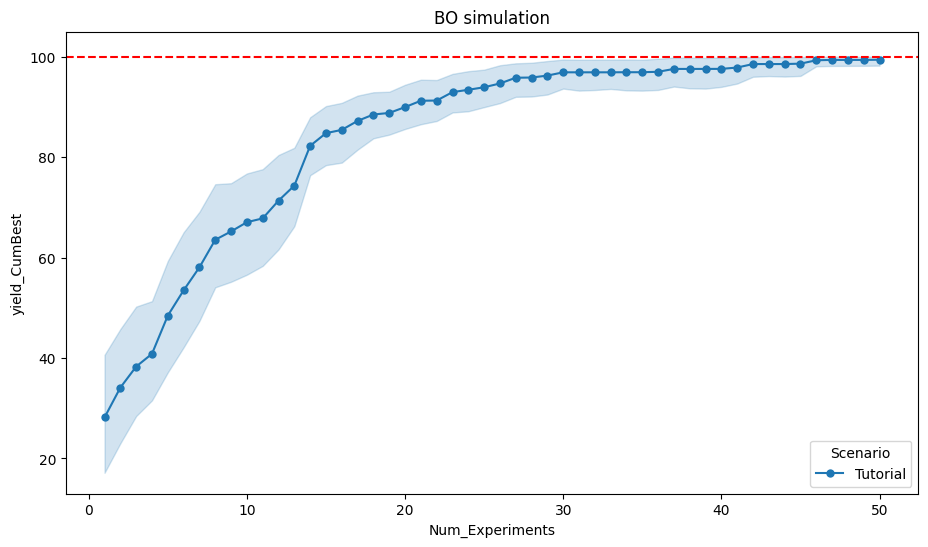

In [12]:
#=======================================================
# 5. View the results
#=======================================================
import seaborn as sns
import matplotlib.pyplot as plt

PLOTARGS = {
    'linestyle': 'solid',
    'marker': 'o',
    'markersize': 6,
    'markeredgecolor': 'none'
}

sns.lineplot(data = result,
            x = "Num_Experiments",
            y = "yield_CumBest",
            hue = "Scenario",
             **PLOTARGS)

plt.axhline(y = F_BEST, color = 'red', linestyle = '--', label = 'Best Possible')
plt.gcf().set_size_inches((11,6))
plt.gca().set_ylim(plt.gca().get_ylim()[0], F_BEST+5)
plt.title(f'BO simulation')